# Unsupervised learning

Sometimes we have data but don't exactly know the {term}`labels` or {term}`classes` that each sample should have. This is common in Earth and Environmental Sciences and a good example of it are multi-spectral satellite images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import pooch
from sklearn import (
    preprocessing, 
    decomposition,
    cluster, 
)

## Download some data

Let's download some Landsat8 satellite imagery of the [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) using [Pooch](https://www.fatiando.org/pooch).

In [2]:
base_url = "https://github.com/leouieda/remote-sensing/raw/main/data/thomas_fire/LC08_L2SP_042036_20180126_20200902_02_T1_cropped"

In [3]:
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]
band_numbers = [2, 3, 4, 5, 6, 7]
bands = {}
for number, name in zip(band_numbers, band_names):
    url = f"{base_url}/LC08_L2SP_042036_20180126_20200902_02_T1_B{number}.TIF"
    fname = pooch.retrieve(url, known_hash=None)
    band = 2.75e-05 * skimage.io.imread(fname).astype("float32") - 0.2 
    bands[name] = band
shape = bands["blue"].shape

Plot the different bands of the image.

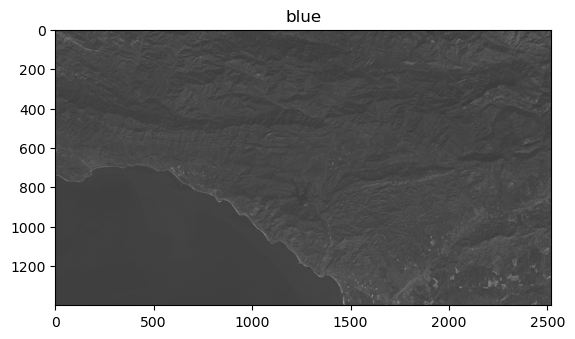

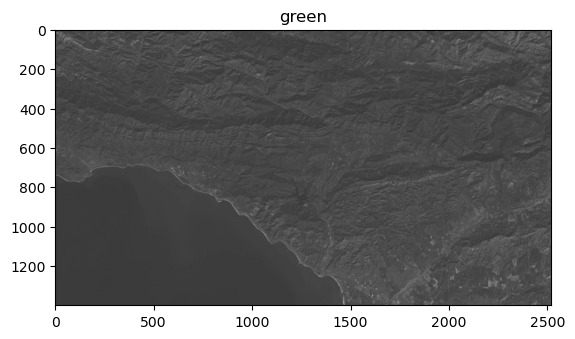

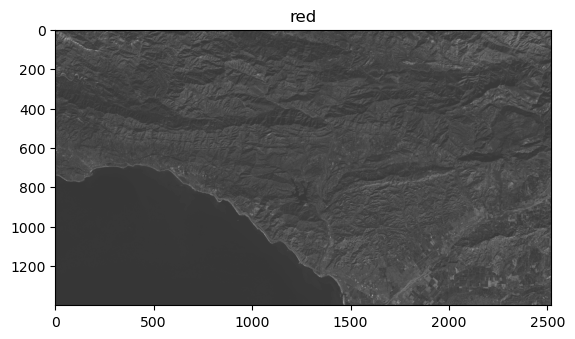

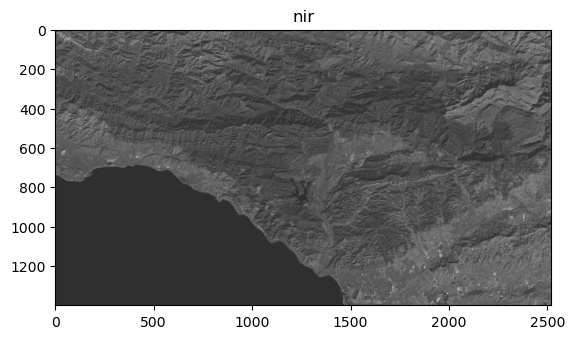

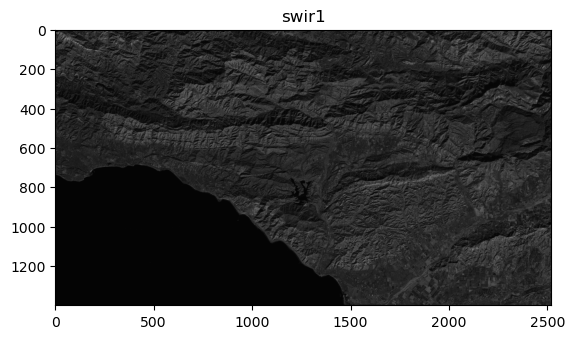

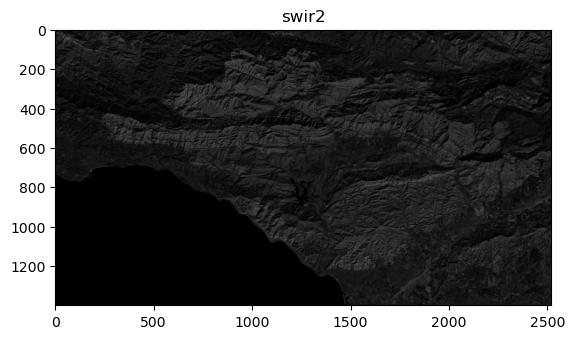

In [4]:
for name in bands:
    plt.figure()
    plt.title(name)
    plt.imshow(bands[name], cmap="gray")

## Prepare data for machine learning

For machine learning, we'll need to have a matrix of samples and features. Samples are measurements and features are different aspects of a sample. In this case, each pixel will be a sample and each frequency band is a feature of that pixel.

So let's transform our numpy arrays into a table of features and samples.

In [5]:
features = pd.DataFrame({n: bands[n].ravel() for n in bands})
features

,blue,green,red,nir,swir1,swir2
0,0.015243,0.023162,0.023520,0.085560,0.074918,0.056438
1,0.018955,0.027865,0.033695,0.099805,0.092022,0.065980
2,0.022090,0.033090,0.040130,0.093480,0.094360,0.066420
3,0.024290,0.037518,0.044227,0.090400,0.086467,0.061745
4,0.014527,0.021650,0.024895,0.054017,0.047857,0.032458
...,...,...,...,...,...,...
3527995,0.058885,0.093012,0.129202,0.346618,0.297503,0.187228
3527996,0.047885,0.080115,0.100300,0.297448,0.251468,0.154970
3527997,0.040267,0.063202,0.067382,0.279188,0.164292,0.108578
3527998,0.038617,0.068400,0.073845,0.275530,0.203397,0.134455


Finally, get a matrix out of this table that can be passed to scikit-learn.

In [6]:
X = features.values
X

array([[0.0152425 , 0.0231625 , 0.02351999, 0.08556001, 0.07491751,
        0.05643751],
       [0.01895499, 0.02786499, 0.033695  , 0.09980501, 0.09202249,
        0.06598   ],
       [0.02209   , 0.03309   , 0.04013   , 0.09348001, 0.09436001,
        0.06642   ],
       ...,
       [0.0402675 , 0.06320249, 0.0673825 , 0.2791875 , 0.1642925 ,
        0.1085775 ],
       [0.03861749, 0.06840001, 0.07384501, 0.27552998, 0.2033975 ,
        0.13445501],
       [0.04937001, 0.070765  , 0.08429499, 0.23235501, 0.1868975 ,
        0.13682   ]], dtype=float32)

## Some data exploration

Let's plot histograms of each feature to try to explore our data distributions a bit. This helps us get a sense for the range of values and scales.

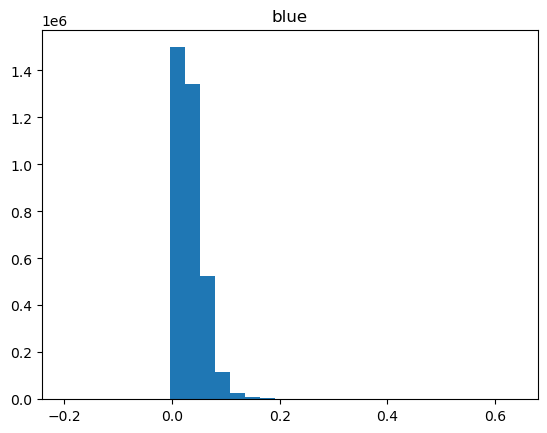

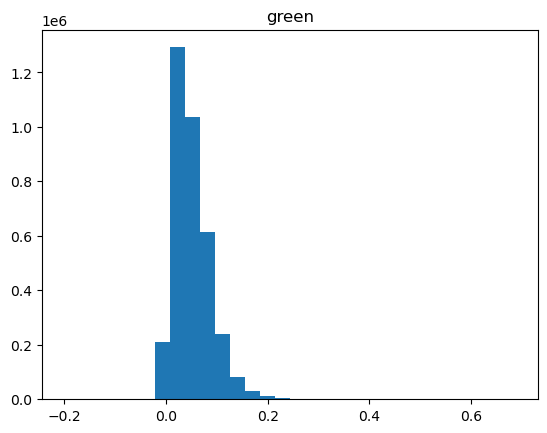

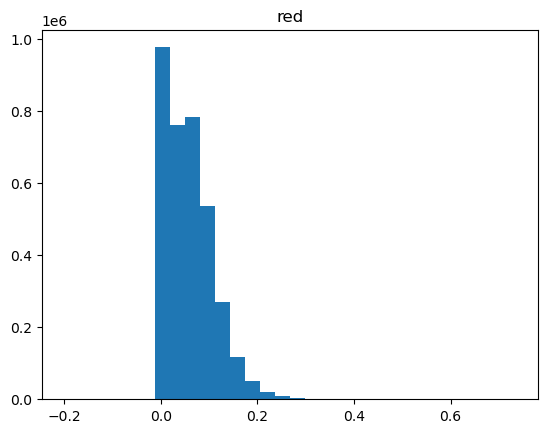

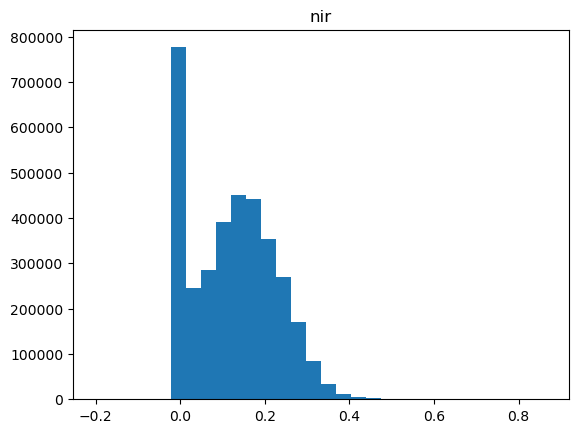

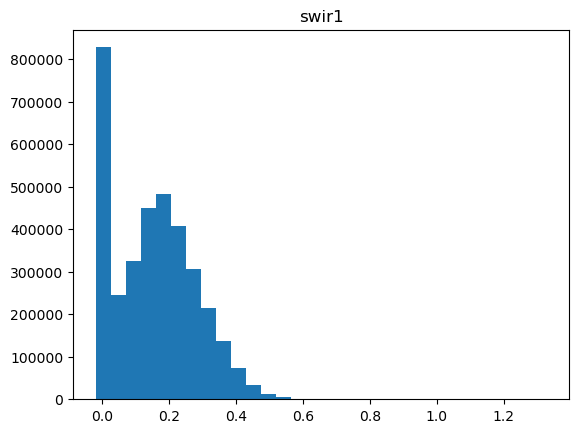

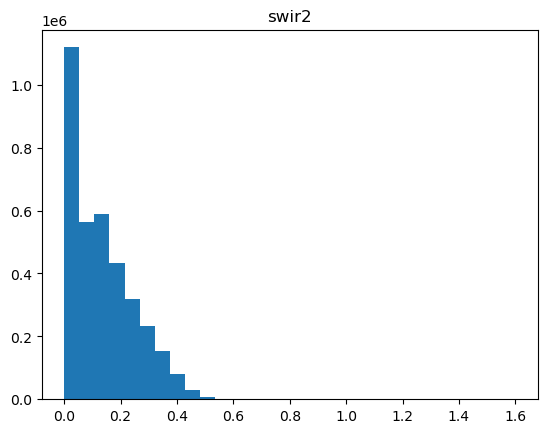

In [11]:
for i, band in enumerate(band_names):
    plt.figure()
    plt.title(band)
    plt.hist(X[:, i], bins=30)
plt.show()

## Clustering

Can we group together pixels from the burned areas automatically? Let's try KMeans clustering on our raw data.

In [7]:
%%time
kmeans = cluster.KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

CPU times: user 1min 5s, sys: 17.4 s, total: 1min 22s
Wall time: 15.9 s


KMeans(n_clusters=5, random_state=0)

Add the clusters to the data table so we can manipulate it later.

In [8]:
features["clusters"] = kmeans.predict(X)
features

,blue,green,red,nir,swir1,swir2,clusters
0,0.015243,0.023162,0.023520,0.085560,0.074918,0.056438,3
1,0.018955,0.027865,0.033695,0.099805,0.092022,0.065980,3
2,0.022090,0.033090,0.040130,0.093480,0.094360,0.066420,3
3,0.024290,0.037518,0.044227,0.090400,0.086467,0.061745,3
4,0.014527,0.021650,0.024895,0.054017,0.047857,0.032458,1
...,...,...,...,...,...,...,...
3527995,0.058885,0.093012,0.129202,0.346618,0.297503,0.187228,0
3527996,0.047885,0.080115,0.100300,0.297448,0.251468,0.154970,0
3527997,0.040267,0.063202,0.067382,0.279188,0.164292,0.108578,0
3527998,0.038617,0.068400,0.073845,0.275530,0.203397,0.134455,0


Plot the cluster label by pixel as an image.

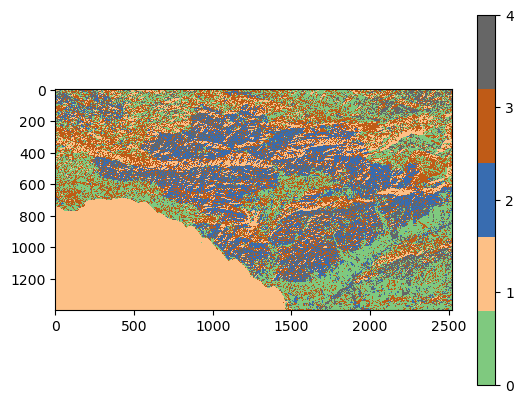

In [27]:
cluster_image = features.clusters.values.reshape(shape)

cmap = plt.cm.get_cmap("Accent", features.clusters.unique().size)
plt.figure()
plt.imshow(cluster_image, cmap=cmap, interpolation="none")
plt.colorbar(ticks=features.clusters.unique())
plt.show()

Not bad! We can see the water, burned area, and some other things in this image.

Now let's investigate. Let's plot the mean reflectance per band per cluster. We'll so some pandas magic to make this work.

<AxesSubplot: >

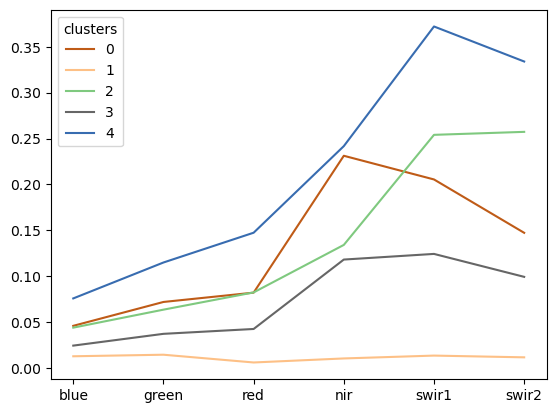

In [57]:
mean_per_band = features.groupby("clusters").mean()
mean_per_band[band_names].T.plot(color=cmap(features.clusters.unique()))

Now let's try to improve this.

## Principle Component Analysis - PCA

First, let's analyze the different contributions of principle components in the data using PCA.

In [58]:
%%time
pca = decomposition.PCA()
pca.fit(X)

CPU times: user 1.37 s, sys: 2.24 s, total: 3.61 s
Wall time: 1.6 s


PCA()

In [21]:
print("Cummulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

Cummulative explained variance: [0.87282795 0.97524129 0.99571475 0.99895513 0.99976925 1.        ]


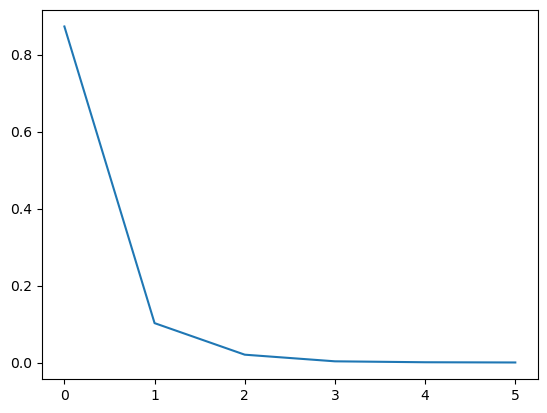

In [20]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)

From the plot and cummulative explained variance we can tell that we only need 3 components to explain 99% of the variance in the data. So let's run PCA again but tell it to create a new feature matrix using only those 3 components.

In [59]:
%%time
Xpca = decomposition.PCA(n_components=3).fit_transform(X)
Xpca

CPU times: user 11.2 s, sys: 21.4 s, total: 32.6 s
Wall time: 8.09 s


array([[-0.12351574, -0.01334879, -0.01007347],
       [-0.09759637, -0.01897126, -0.00734692],
       [-0.09578812, -0.01419561,  0.00206533],
       ...,
       [ 0.065117  , -0.14079545, -0.02001397],
       [ 0.10515343, -0.1196523 , -0.02293331],
       [ 0.0817511 , -0.08609285,  0.00257737]], dtype=float32)

Plot images of each of these components to see what they look like spatially.

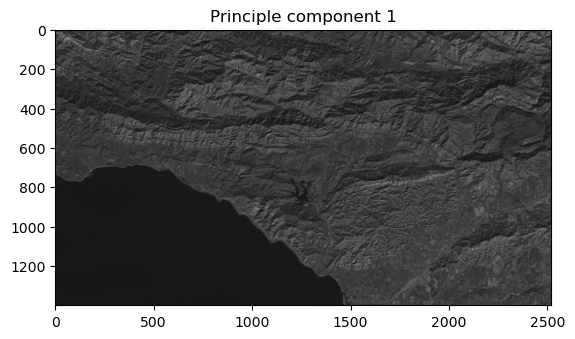

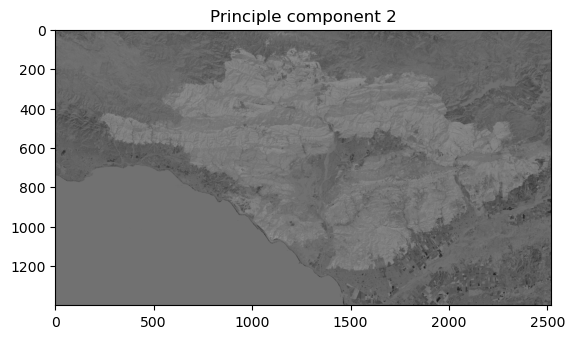

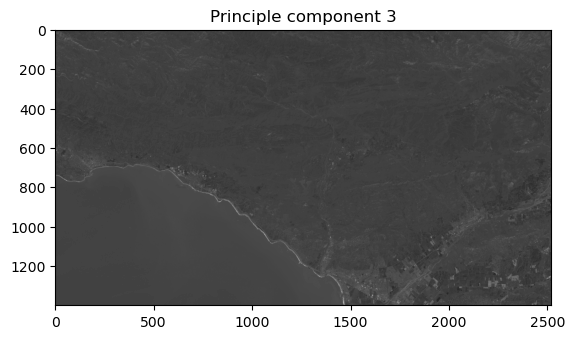

In [24]:
for i, component in enumerate(Xpca.T):
    plt.figure()
    plt.title(f"Principle component {i + 1}")
    plt.imshow(component.reshape(shape), cmap="gray")
plt.show()

Now try KMeans again on the principle components instead of the original data.

In [60]:
%%time
kmeans_pca = cluster.KMeans(n_clusters=5, random_state=0).fit(Xpca)
features["clusters_pca"] = kmeans_pca.predict(Xpca)

CPU times: user 44.6 s, sys: 12 s, total: 56.6 s
Wall time: 23.4 s


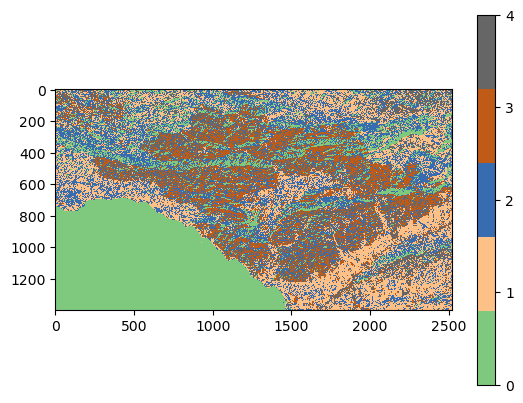

In [61]:
cluster_image = features.clusters_pca.values.reshape(shape)

cmap = plt.cm.get_cmap("Accent", features.clusters_pca.unique().size)
plt.figure()
plt.imshow(cluster_image, cmap=cmap, interpolation="none")
plt.colorbar(ticks=features.clusters_pca.unique())
plt.show()

<Figure size 640x480 with 0 Axes>

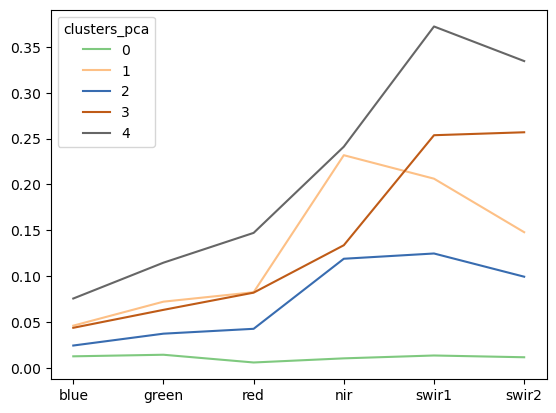

In [62]:
plt.figure()
features.groupby("clusters_pca").mean()[band_names].T.plot(color=cmap(sorted(features.clusters_pca.unique())))
plt.show()

Not bad but also not an improvement on our original estimate. PCA doesn't work in every case and it looks like this is one of them.

## Independent Component Analysis - ICA

Let's try a different decomposition method: ICA. It works well when done on data that has undergone PCA already.

In [63]:
%%time
Xica = decomposition.FastICA(random_state=0, whiten="unit-variance").fit_transform(Xpca)

CPU times: user 7.73 s, sys: 7.7 s, total: 15.4 s
Wall time: 3.12 s


Plot the independent components.

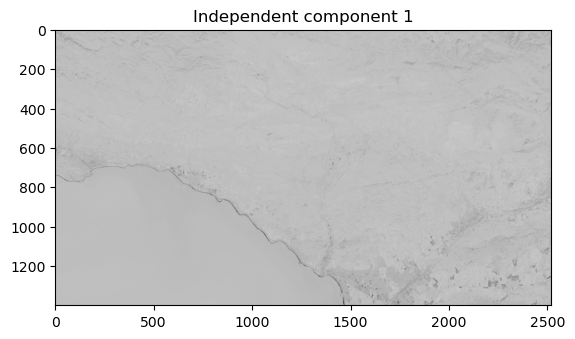

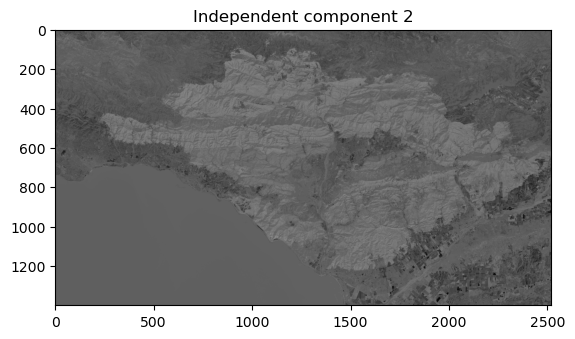

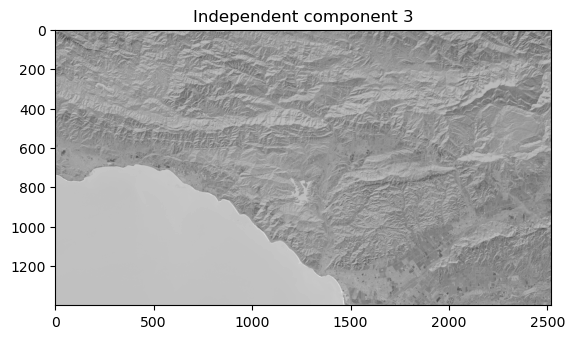

In [64]:
for i, component in enumerate(Xica.T):
    plt.figure()
    plt.title(f"Independent component {i + 1}")
    plt.imshow(component.reshape(shape), cmap="gray")
plt.show()

And now run KMeans on the independent components.

In [65]:
%%time
kmeans_ica = cluster.KMeans(n_clusters=5, random_state=0).fit(Xica)
features["clusters_ica"] = kmeans_ica.predict(Xica)

CPU times: user 1min 33s, sys: 14.2 s, total: 1min 47s
Wall time: 30.3 s


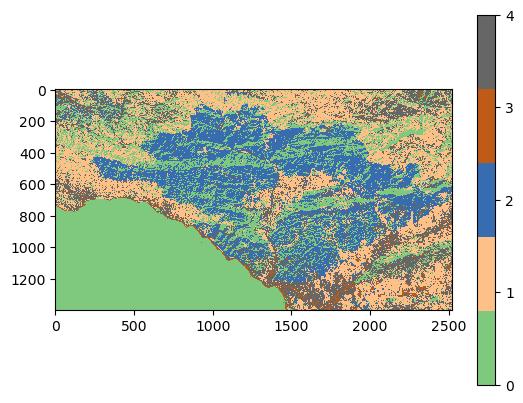

In [66]:
cluster_image = features.clusters_ica.values.reshape(shape)

cmap = plt.cm.get_cmap("Accent", features.clusters_ica.unique().size)
plt.figure()
plt.imshow(cluster_image, cmap=cmap, interpolation="none")
plt.colorbar(ticks=features.clusters_ica.unique())
plt.show()

<Figure size 640x480 with 0 Axes>

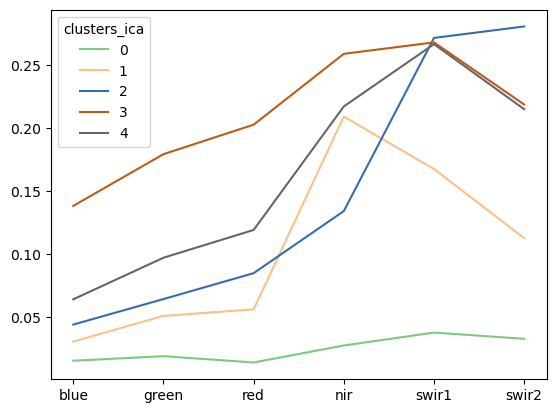

In [ ]:
plt.figure()
features.groupby("clusters_ica").mean()[band_names].T.plot(color=cmap(sorted(features.clusters_ica.unique())))
plt.show()

This is now an improvement. We can see clearer separation between the clusters. Cluster 1 has a strong NIR reflection, characteristic of vegetation. Cluster 0 is a mix of water and shadows. Cluster 2 is our fire with very strong reflection on SWIR bands. Cluster 3 is interesting since it isn't on the original clustering but it seems to outline the sandy beach that has very strong reflectance throughout.